In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from transformers import SamProcessor, SamModel
import gc

In [5]:
def load_yolo_annotations(yolo_file):
    with open(yolo_file, 'r') as file:
        annotations = file.readlines()
    bboxes = []
    for annotation in annotations:
        parts = annotation.strip().split()
        x_center, y_center, width, height = map(float, parts[1:])
        bboxes.append((x_center, y_center, width, height))
    return bboxes

def draw_bboxes(image, bboxes):
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        x_center, y_center, width, height = bbox
        left = (x_center - width / 2) * image.width
        right = (x_center + width / 2) * image.width
        top = (y_center - height / 2) * image.height
        bottom = (y_center + height / 2) * image.height
        draw.rectangle([left, top, right, bottom], outline="red", width=2)
    return image

def create_binary_mask(image_shape, bboxes):
    # Create a blank binary mask
    binary_mask = np.zeros(image_shape[:2], dtype=np.uint8)

    # Set pixels inside bounding boxes to 1
    for bbox in bboxes:
        x_center, y_center, width, height = bbox
        left = int((x_center - width / 2) * image_shape[1])
        right = int((x_center + width / 2) * image_shape[1])
        top = int((y_center - height / 2) * image_shape[0])
        bottom = int((y_center + height / 2) * image_shape[0])

        binary_mask[top:bottom, left:right] = 1

    return binary_mask

def show_binary_mask(binary_mask):
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Binary Mask")
    plt.axis('off')
    plt.show()

def apply_mask_to_image(image, binary_mask):
    # Ensure image and mask are the same size
    if image.size != (binary_mask.shape[1], binary_mask.shape[0]):
        raise ValueError("Image and mask must have the same dimensions.")

    # Convert image to numpy array
    image_array = np.array(image)

    # Apply the mask: Set pixels inside the mask to black
    masked_image = image_array.copy()
    masked_image[binary_mask == 1] = 0  # Set foreground pixels (inside bounding boxes) to black

    # Convert back to PIL image
    masked_image = Image.fromarray(masked_image)
    return masked_image

def main(image_path, yolo_file, another_image_path, save_mask=False, mask_save_path="binary_mask.png"):
    image = Image.open(image_path).convert("RGB")
    bboxes = load_yolo_annotations(yolo_file)
    image_with_bboxes = draw_bboxes(image.copy(), bboxes)
    
    # Create the binary mask based on bounding boxes
    binary_mask = create_binary_mask(image.size[::-1], bboxes)  # image.size is (width, height)

    # Display the binary mask
    show_binary_mask(binary_mask)

    # Save the binary mask if the option is selected
    if save_mask:
        plt.imsave(mask_save_path, binary_mask, cmap='gray')
        print(f"Binary mask saved to {mask_save_path}")

    # Load another image
    another_image = Image.open(another_image_path).convert("RGB")

    # Resize the other image to match the size of the mask
    another_image_resized = another_image.resize(image.size)

    # Apply the mask to the other image, preserving the content outside the mask
    masked_image = apply_mask_to_image(another_image_resized, binary_mask)

    # Display the masked image
    plt.imshow(masked_image)
    plt.title("Masked Image (Contents Outside Bounding Boxes Preserved)")
    plt.axis('off')
    plt.show()

    # Optionally, save the masked image
    if save_mask:
        masked_image.save("masked_image_outside_preserved.png")
        print("Masked image saved as masked_image_outside_preserved.png")

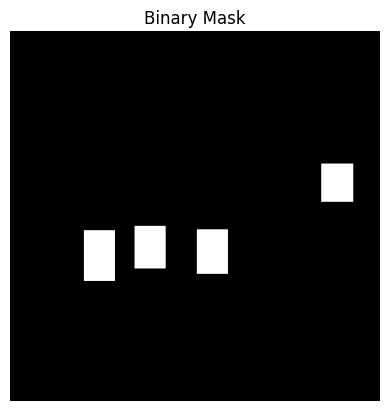

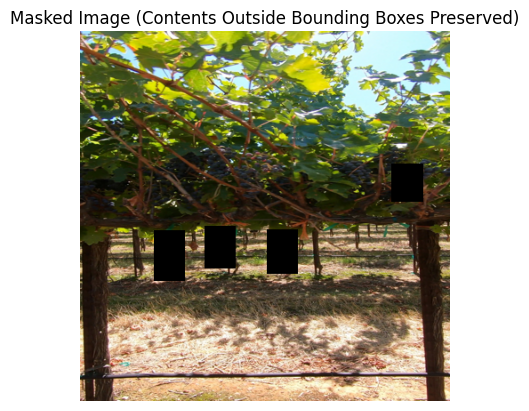

In [6]:
image_path = "/data2/eranario/data/yolo_grl_data/BordenNight/Synthetic/images/00001.jpg"
real_image_path = "/data2/eranario/data/yolo_grl_data/CropGANData/detection_datasets/BordenDayRow/train/images/GH010070000300.jpg"
# image_path = "/group/jmearlesgrp/data/yolo_grl_data/GEMINI_Flowers/Synthetic/images/camA_cowpea_018_000_3710807_RGB.jpeg"
yolo_file = "/data2/eranario/data/yolo_grl_data/BordenNight/Synthetic/labels/00001.txt"
# yolo_file = "/group/jmearlesgrp/data/yolo_grl_data/GEMINI_Flowers/Synthetic/labels/camA_cowpea_018_000_3710807_RGB.txt"
main(image_path, yolo_file, real_image_path)